In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list
from utils.analysis import compute_parametric_modulator

In [4]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

sub_ids = load_participant_list(base_dir)

In [5]:
#subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]
subject = Subject(base_dir, '01', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

# Setting parameters

In [ ]:
model_name = 'no_modulation'
tr = 2.33384
hrf_model = 'spm'
noise_model = 'ar1'
smoothing_fwhm = 5
high_pass = 0.01
motion_type = 'basic'

run = 'test'
# ref to the block
block = getattr(subject, run)

# Get the data

In [12]:
img_path = subject.img.get(run)
fmri_img = image.load_img(img_path)

In [13]:
confounds, sample_mask  = subject.load_confounds(run, motion_type=motion_type)

In [14]:
physio_regressors = subject.load_physio_regressors(run)

# No parametric modulation

In [11]:
n = fmri_img.shape[-1]
frametimes = np.linspace(tr/2., (n - .5)*tr, n) # from Gilles, checked with nilearn FirstLevelModel

In [12]:
X1 = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
response.
  warnings.warn(
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: first_stim_value_ck, first_stim_value_rl, trial
  warnings.warn(


In [13]:
model1 = FirstLevelModel(smoothing_fwhm=smoothing_fwhm)
model1 = model1.fit(fmri_img, design_matrices=X1, sample_masks=sample_mask)

# Plotting results

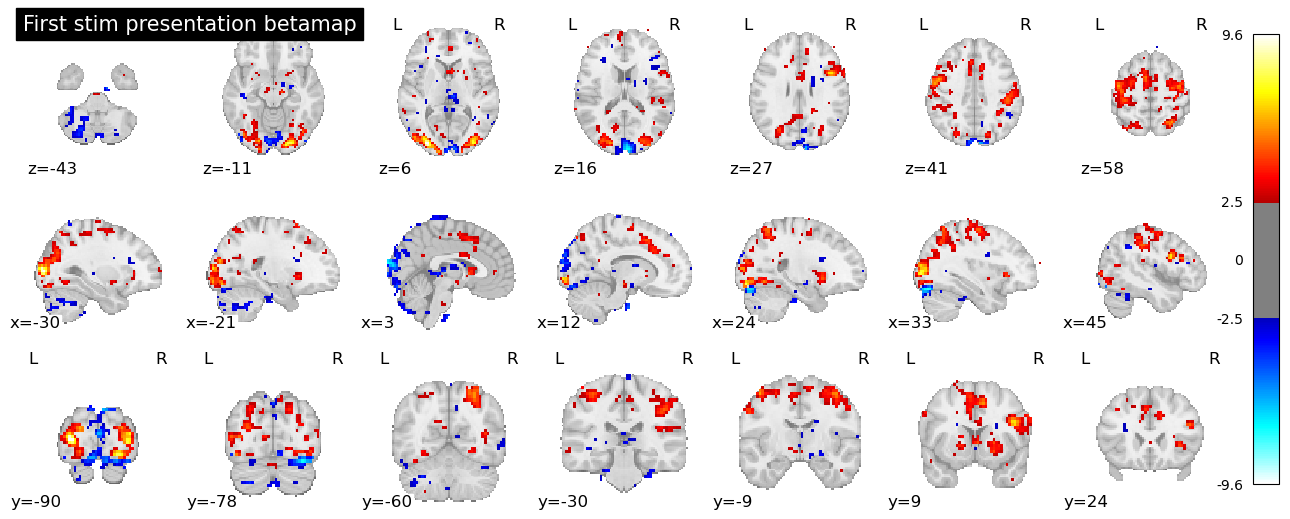

In [14]:
z_map1 = model1.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)

plot_stat_map(
    z_map1,
    threshold=2.5,
    display_mode="mosaic",
    title=f"First stim presentation betamap",
)

# Parametric modulation

In [15]:
condition = 'first_stim_presentation'

reg_rl_value = compute_parametric_modulator(events, condition, 'first_stim_value_rl',
                                            frametimes, hrf_model)
reg_ck_value = compute_parametric_modulator(events, condition, 'first_stim_value_ck',
                                            frametimes, hrf_model)

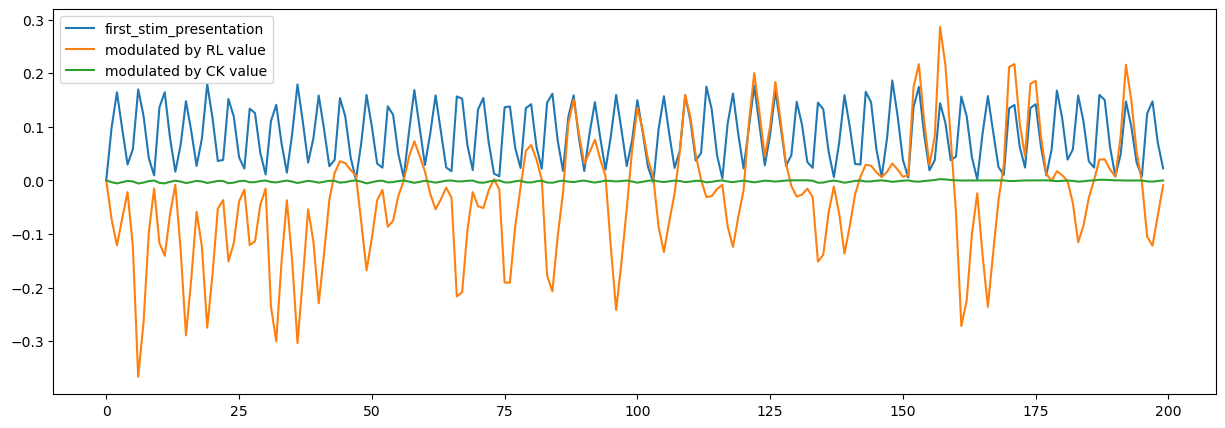

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(X1[condition].values[:200], label=condition)
plt.plot(reg_rl_value[:200], label = 'modulated by RL value')
plt.plot(reg_ck_value[:200], label = 'modulated by CK value')
plt.legend()
plt.show()

In [17]:
X_complete = X1.copy()
X_complete.insert(1, 'first_stim_value_rl', reg_rl_value)
X_complete.insert(2, 'first_stim_value_ck', reg_ck_value)

In [18]:
model2 = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=False)#, mask_img=bartra_mask_path)
model2 = model2.fit(fmri_img, design_matrices=X_complete, sample_masks=sample_mask)

# Check correlation between regressors

In [19]:
# import seaborn as sns
# # Compute the correlation matrix
# corr = X_complete.corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Handling orthogonalization

In [20]:
unmodulated = X_complete.first_stim_presentation.values.reshape(-1, 1)
# RL
model = LinearRegression().fit(unmodulated, reg_rl_value)
rl_value_ortho = reg_rl_value - model.predict(unmodulated)
# CK
model = LinearRegression().fit(unmodulated, reg_ck_value)
ck_value_ortho = reg_ck_value - model.predict(unmodulated)

In [21]:
X_ortho = X_complete.copy()
X_ortho['first_stim_value_rl'] = rl_value_ortho
X_ortho['first_stim_value_ck'] = ck_value_ortho

In [22]:
model3 = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=False)#, mask_img=bartra_mask_path)
model3 = model3.fit(fmri_img, design_matrices=X_ortho, sample_masks=sample_mask)

In [23]:
corr_unmod_rl = np.corrcoef(unmodulated.flatten(), reg_rl_value.flatten())[0, 1]
corr_rl_ck = np.corrcoef(reg_rl_value.flatten(), reg_ck_value.flatten())[0, 1]
corr_unmod_rl_ortho = np.corrcoef(unmodulated.flatten(), rl_value_ortho.flatten())[0, 1]
corr_rl_ortho_ck_ortho = np.corrcoef(rl_value_ortho.flatten(), ck_value_ortho.flatten())[0, 1]

print(f"Correlation between unmodulated and RL value: {corr_unmod_rl:.4f}")
print(f"Correlation between RL value and CK value: {corr_rl_ck:.4f}")
print(f"Correlation between unmodulated and orthogonalized RL value: {corr_unmod_rl_ortho:.4f}")
print(f"Correlation between orthogonalized RL value and orthogonalized CK value: {corr_rl_ortho_ck_ortho:.4f}")

Correlation between unmodulated and RL value: 0.0097
Correlation between RL value and CK value: 0.5573
Correlation between unmodulated and orthogonalized RL value: -0.0000
Correlation between orthogonalized RL value and orthogonalized CK value: 0.5573


# Plotting results

In [24]:
z_map_pres = model3.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_rl = model3.compute_contrast(
    contrast_def="first_stim_value_rl", output_type="z_score"
)
z_map_ck = model3.compute_contrast(
    contrast_def="first_stim_value_ck", output_type="z_score"
)

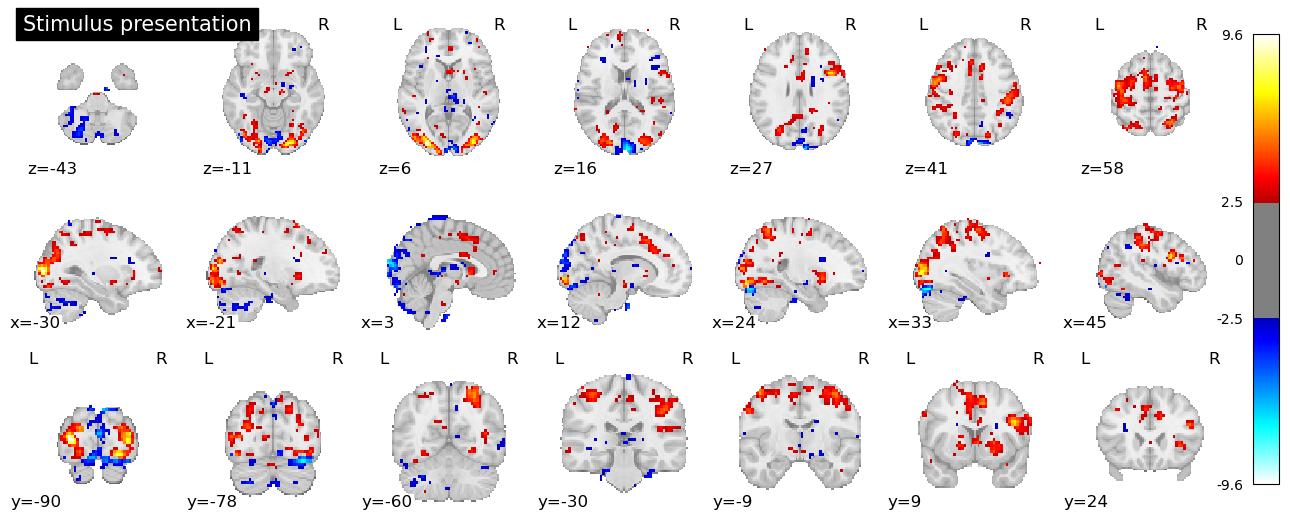

In [25]:
plot_stat_map(
    z_map_pres,
    threshold=2.5,
    display_mode="mosaic",
    title=f"Stimulus presentation",
)

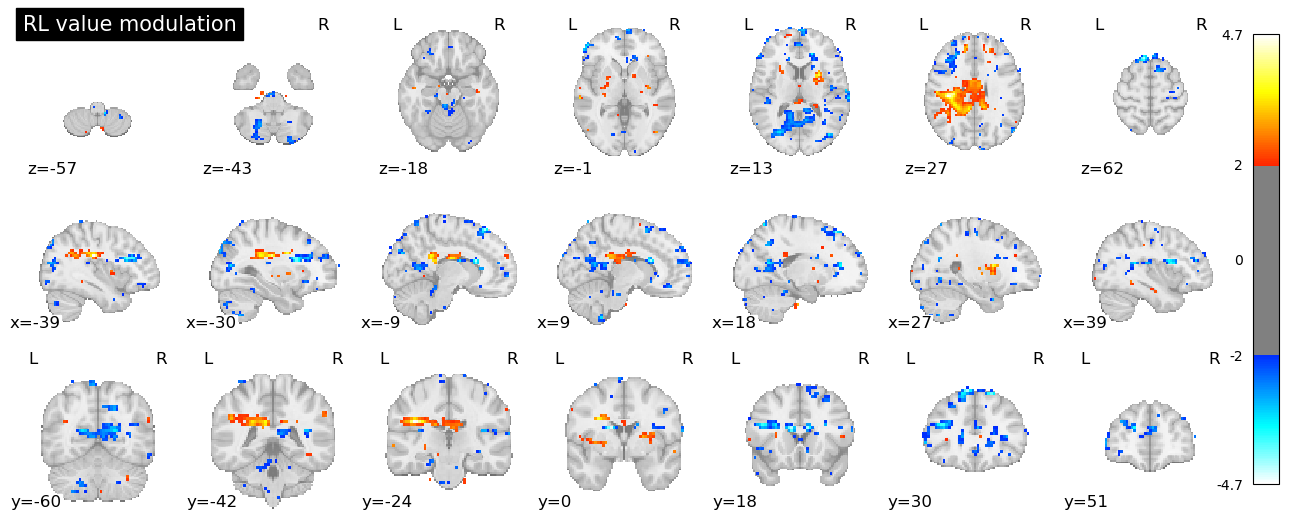

In [26]:
plot_stat_map(
    z_map_rl,
    threshold=2,
    display_mode="mosaic",
    title=f"RL value modulation",
)

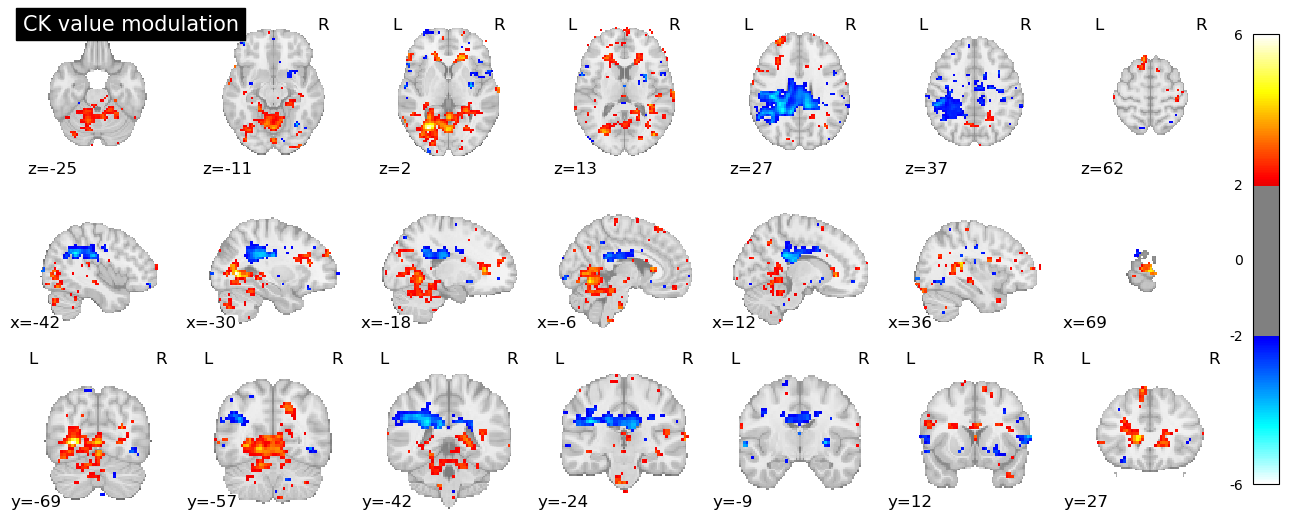

In [27]:
plot_stat_map(
    z_map_ck,
    threshold=2,
    display_mode="mosaic",
    title=f"CK value modulation",
)

## Correlation at the beta map level

In [28]:
np.corrcoef(z_map_pres.get_fdata().ravel(), z_map_rl.get_fdata().ravel())[0,1]

0.030290566708161066

In [29]:
np.corrcoef(z_map_rl.get_fdata().ravel(), z_map_ck.get_fdata().ravel())[0,1]

-0.6270477480199873

In [30]:
np.corrcoef(z_map1.get_fdata().ravel(), z_map_pres.get_fdata().ravel())[0,1]

0.9996817449939257

## Different model comparison
The correlation between the beta maps for First Stim Presentation for the Model 1, which includes no parametric regulation and the Model 3, which includes orthogonalised parametric modulation shows, is almost 1.
Now let's do the same with the non-orthogonalised Model 2.

In [31]:
z_map_pres_2 = model2.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_rl_2 = model2.compute_contrast(
    contrast_def="first_stim_value_rl", output_type="z_score"
)
z_map_ck_2 = model2.compute_contrast(
    contrast_def="first_stim_value_ck", output_type="z_score"
)

In [32]:
np.corrcoef(z_map1.get_fdata().ravel(), z_map_pres_2.get_fdata().ravel())[0,1]

0.9996238565278106

In [33]:
np.corrcoef(z_map_rl.get_fdata().ravel(), z_map_rl_2.get_fdata().ravel())[0,1]

0.9999999999999979

In [34]:
np.corrcoef(z_map_ck.get_fdata().ravel(), z_map_ck_2.get_fdata().ravel())[0,1]

0.9999999999999996

In [35]:
np.corrcoef(z_map_rl_2.get_fdata().ravel(), z_map_ck_2.get_fdata().ravel())[0,1]

-0.6270477480273616

In [36]:
np.corrcoef(reg_rl_value.flatten(), reg_ck_value.flatten())[0, 1]

0.5573293320069531

# Split modeling of the 2 modulators

In [37]:
# Build the design matrix
X_rl = X1.copy()
X_rl.insert(1, 'first_stim_value_rl', reg_rl_value)

# Fit the first-level model
modelRL = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=True)
modelRL = modelRL.fit(fmri_img, design_matrices=X_rl, sample_masks=sample_mask)

In [38]:
# Build the design matrix
X_ck = X1.copy()
X_ck.insert(1, 'first_stim_value_ck', reg_ck_value)

# Fit the first-level model
modelCK = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=True)
modelCK = modelCK.fit(fmri_img, design_matrices=X_ck, sample_masks=sample_mask)

In [39]:
z_map_pres_rl = modelRL.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_pres_ck = modelCK.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_rl_only = modelRL.compute_contrast(
    contrast_def="first_stim_value_rl", output_type="z_score"
)
z_map_ck_only = modelCK.compute_contrast(
    contrast_def="first_stim_value_ck", output_type="z_score"
)

In [40]:
np.corrcoef(z_map_pres_rl.get_fdata().ravel(), z_map_pres_2.get_fdata().ravel())[0,1]

0.9996980938288051

In [41]:
np.corrcoef(z_map_pres_rl.get_fdata().ravel(), z_map_pres_ck.get_fdata().ravel())[0,1]

0.9997878330322496

In [42]:
np.corrcoef(z_map_rl_only.get_fdata().ravel(), z_map_rl.get_fdata().ravel())[0,1]

0.7987720004755016

In [43]:
np.corrcoef(z_map_ck_only.get_fdata().ravel(), z_map_ck.get_fdata().ravel())[0,1]

0.883486909680524

In [44]:
np.corrcoef(z_map_rl_only.get_fdata().ravel(), z_map_ck_only.get_fdata().ravel())[0,1]

0.4396436822860321

## Results of splitting models
Despite fitting models separately, the correlation between the beta maps of the RL and CK modulations remains really high, especially in the Test run